# Multivariate Analysis of Glycaemic Control Using Demographic, Lifestyle, and Clinical Predictors in Type 1 Diabetes

### Setup & Imports

In [1]:
# ============================================================
# SETUP: install (if needed) + imports
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

### Load Dataset

In [2]:
# ============================================================
# Load Data
# ============================================================

df = pd.read_csv("weinstock.csv")

# To see all the columns in the data
pd.set_option('display.max_columns', None)

print("Shape:", df.shape)
df.head()


Shape: (647858, 41)


,id,gl,time,Gender,Race,EduLevel,AnnualInc,MaritalStatus,DaysWkEx,DaysWkDrinkAlc,DaysMonBingeAlc,T1DDiagAge,NumHospDKA,NumSHSinceT1DDiag,InsDeliveryMethod,UnitsInsTotal,NumMeterCheckDay,Height,Weight,Hypertension,Hyperlipidemia,Hypothyroidism,Depression,Coronary artery disease,Diabetic peripheral neuropathy,Dyslipidemia,Chronic kidney disease,Osteoporosis,Proliferative diabetic retinopathy,Hypercholesterolemia,Erectile dysfunction,Type I diabetes mellitus,Aspirin,Simvastatin,Lisinopril,Vitamin D,Multivitamin preparation,Omeprazole,atorvastatin,Synthroid,vitamin D3
0,199,200.0,1900-01-01 17:49:32,F,White,7,2,Married,7.0,0.0,0.0,35,2.0,7,Pump,25.0,7,64.173263,178.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,199,195.0,1900-01-01 17:54:32,F,White,7,2,Married,7.0,0.0,0.0,35,2.0,7,Pump,25.0,7,64.173263,178.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,199,236.0,1900-01-01 20:29:31,F,White,7,2,Married,7.0,0.0,0.0,35,2.0,7,Pump,25.0,7,64.173263,178.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,199,210.0,1900-01-01 20:34:31,F,White,7,2,Married,7.0,0.0,0.0,35,2.0,7,Pump,25.0,7,64.173263,178.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,199,196.0,1900-01-01 20:39:31,F,White,7,2,Married,7.0,0.0,0.0,35,2.0,7,Pump,25.0,7,64.173263,178.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
# Inspect EduLevel codes
print("dtype:", df["EduLevel"].dtype)
print("unique codes:", sorted(df["EduLevel"].dropna().unique()))
print(df["EduLevel"].value_counts())

# Map numeric codes -> readable labels (replace values with your dataset's true labels)
edu_map = {
    0: "No formal",
    1: "Primary",
    2: "Secondary",
    3: "Intermediate",
    4: "Graduate",
    5: "Postgraduate",
    6: "Other"
}
df["EduLevel_label"] = df["EduLevel"].map(edu_map).fillna(df["EduLevel"].astype(str))
df["EduLevel_label"] = df["EduLevel_label"].astype("category")

In [3]:
# ============================================================
# Check how many times 'id' is 199 in the dataset to verify the gulocose values
# ============================================================
id_199_count = df[df['id'] == 199].shape[0]
print(f"Count of 'id' where id is 199: {id_199_count}")

Count of 'id' where id is 199: 2820


In [4]:
df[df['id'] == 199].head(10)

,id,gl,time,Gender,Race,EduLevel,AnnualInc,MaritalStatus,DaysWkEx,DaysWkDrinkAlc,DaysMonBingeAlc,T1DDiagAge,NumHospDKA,NumSHSinceT1DDiag,InsDeliveryMethod,UnitsInsTotal,NumMeterCheckDay,Height,Weight,Hypertension,Hyperlipidemia,Hypothyroidism,Depression,Coronary artery disease,Diabetic peripheral neuropathy,Dyslipidemia,Chronic kidney disease,Osteoporosis,Proliferative diabetic retinopathy,Hypercholesterolemia,Erectile dysfunction,Type I diabetes mellitus,Aspirin,Simvastatin,Lisinopril,Vitamin D,Multivitamin preparation,Omeprazole,atorvastatin,Synthroid,vitamin D3
0,199,200.0,1900-01-01 17:49:32,F,White,7,2,Married,7.0,0.0,0.0,35,2.0,7,Pump,25.0,7,64.173263,178.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,199,195.0,1900-01-01 17:54:32,F,White,7,2,Married,7.0,0.0,0.0,35,2.0,7,Pump,25.0,7,64.173263,178.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,199,236.0,1900-01-01 20:29:31,F,White,7,2,Married,7.0,0.0,0.0,35,2.0,7,Pump,25.0,7,64.173263,178.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,199,210.0,1900-01-01 20:34:31,F,White,7,2,Married,7.0,0.0,0.0,35,2.0,7,Pump,25.0,7,64.173263,178.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,199,196.0,1900-01-01 20:39:31,F,White,7,2,Married,7.0,0.0,0.0,35,2.0,7,Pump,25.0,7,64.173263,178.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,199,230.0,1900-01-01 20:54:31,F,White,7,2,Married,7.0,0.0,0.0,35,2.0,7,Pump,25.0,7,64.173263,178.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,199,239.0,1900-01-01 20:59:31,F,White,7,2,Married,7.0,0.0,0.0,35,2.0,7,Pump,25.0,7,64.173263,178.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,199,250.0,1900-01-01 21:04:31,F,White,7,2,Married,7.0,0.0,0.0,35,2.0,7,Pump,25.0,7,64.173263,178.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,199,268.0,1900-01-01 21:09:31,F,White,7,2,Married,7.0,0.0,0.0,35,2.0,7,Pump,25.0,7,64.173263,178.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,199,290.0,1900-01-01 21:14:31,F,White,7,2,Married,7.0,0.0,0.0,35,2.0,7,Pump,25.0,7,64.173263,178.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Basic Cleaning + Time Features + Lag Features (Time-Series)

In [5]:
# ============================================================
# Clean column names    
# ============================================================
df.columns = [c.strip().replace(' ', '_') for c in df.columns]
print(df.columns)

Index(['id', 'gl', 'time', 'Gender', 'Race', 'EduLevel', 'AnnualInc',
       'MaritalStatus', 'DaysWkEx', 'DaysWkDrinkAlc', 'DaysMonBingeAlc',
       'T1DDiagAge', 'NumHospDKA', 'NumSHSinceT1DDiag', 'InsDeliveryMethod',
       'UnitsInsTotal', 'NumMeterCheckDay', 'Height', 'Weight', 'Hypertension',
       'Hyperlipidemia', 'Hypothyroidism', 'Depression',
       'Coronary_artery_disease', 'Diabetic_peripheral_neuropathy',
       'Dyslipidemia', 'Chronic_kidney_disease', 'Osteoporosis',
       'Proliferative_diabetic_retinopathy', 'Hypercholesterolemia',
       'Erectile_dysfunction', 'Type_I_diabetes_mellitus', 'Aspirin',
       'Simvastatin', 'Lisinopril', 'Vitamin_D', 'Multivitamin_preparation',
       'Omeprazole', 'atorvastatin', 'Synthroid', 'vitamin_D3'],
      dtype='object')


In [6]:
#============================================================
#  Explore data types and convert group columns into numeric, categorical, time, id
# ============================================================
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
if 'time' in df.columns: cat_cols = [c for c in cat_cols if c!='time']


print('Numeric cols:', len(num_cols))
print('Categorical cols:', len(cat_cols))
print('Sample numeric:', num_cols[:10])
print('Sample categorical:', cat_cols[:10])

Numeric cols: 36
Categorical cols: 4
Sample numeric: ['id', 'gl', 'EduLevel', 'AnnualInc', 'DaysWkEx', 'DaysWkDrinkAlc', 'DaysMonBingeAlc', 'T1DDiagAge', 'NumHospDKA', 'NumSHSinceT1DDiag']
Sample categorical: ['Gender', 'Race', 'MaritalStatus', 'InsDeliveryMethod']


In [7]:
# ============================================================
# Describe numeric columns
# ============================================================

display(df[num_cols].describe().T)

,count,mean,std,min,25%,50%,75%,max
id,647858.0,99.361198,58.566241,1.0,48.000000,99.0,150.000000,203.00000
gl,647858.0,173.863578,82.542535,39.0,112.000000,161.0,223.000000,401.00000
EduLevel,647858.0,7.785519,2.083849,0.0,6.000000,9.0,9.000000,11.00000
AnnualInc,647858.0,3.544987,2.132227,0.0,2.000000,4.0,5.000000,7.00000
DaysWkEx,647858.0,4.954698,2.075663,0.0,4.000000,5.0,7.000000,7.00000
DaysWkDrinkAlc,647858.0,9.984311,12.088201,0.0,0.000000,4.0,25.000000,30.00000
DaysMonBingeAlc,647858.0,0.068348,0.341231,0.0,0.000000,0.0,0.000000,3.00000
T1DDiagAge,647858.0,28.029899,12.647459,5.0,17.000000,29.0,37.000000,57.00000
NumHospDKA,647858.0,0.053504,0.264390,0.0,0.000000,0.0,0.000000,2.00000
NumSHSinceT1DDiag,647858.0,4.284947,2.672915,0.0,1.000000,5.0,7.000000,7.00000


In [8]:
# ============================================================
# Check missingness in the data
# ============================================================
miss = pd.DataFrame({
'missing_count': df.isnull().sum(),
'missing_pct': df.isnull().mean()*100
}).sort_values('missing_pct', ascending=False)


display(miss.head(60))

,missing_count,missing_pct
id,0,0.0
Hypothyroidism,0,0.0
Coronary_artery_disease,0,0.0
Diabetic_peripheral_neuropathy,0,0.0
Dyslipidemia,0,0.0
Chronic_kidney_disease,0,0.0
Osteoporosis,0,0.0
Proliferative_diabetic_retinopathy,0,0.0
Hypercholesterolemia,0,0.0
Erectile_dysfunction,0,0.0


In [9]:
# ============================================================
# Basic Cleaning & Time-Series Feature Engineering
# ============================================================

# Convert time to datetime
df["time"] = pd.to_datetime(df["time"])

# Sort by patient id and time
df = df.sort_values(["id", "time"]).reset_index(drop=True)

# Create time-based features (hour, day, etc.)
df["hour"] = df["time"].dt.hour
df["dayofweek"] = df["time"].dt.dayofweek
df["dayofmonth"] = df["time"].dt.day
df["month"] = df["time"].dt.month

# Create lag features within each patient
MAX_LAG = 3  # can be increase later (e.g., 6, 12)
for lag in range(1, MAX_LAG + 1):
    df[f"gl_lag_{lag}"] = df.groupby("id")["gl"].shift(lag)

# Drop rows where lag values are NaN (start of each patient sequence)
df_supervised = df.dropna(subset=[f"gl_lag_{lag}" for lag in range(1, MAX_LAG + 1)]).copy()

print("After creating lag features:")
print(df_supervised[[ "id", "time", "gl"] + [f"gl_lag_{lag}" for lag in range(1, MAX_LAG + 1)]].head())
print("New shape:", df_supervised.shape)


After creating lag features:
   id                time     gl  gl_lag_1  gl_lag_2  gl_lag_3
3   1 1900-01-01 18:50:14  223.0     233.0     221.0     223.0
4   1 1900-01-01 18:55:14  214.0     223.0     233.0     221.0
5   1 1900-01-01 19:00:14  211.0     214.0     223.0     233.0
6   1 1900-01-01 19:05:14  206.0     211.0     214.0     223.0
7   1 1900-01-01 19:10:14  208.0     206.0     211.0     214.0
New shape: (647258, 48)


### Exploratory Data Analysis (EDA)

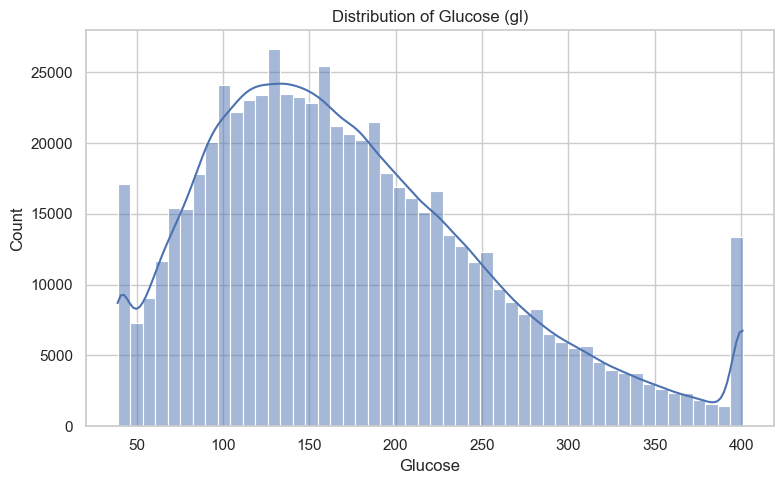

/var/folders/xh/5nmy5p315bd6nlmsjh0j_x980000gr/T/ipykernel_73087/3525330397.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x="hour", y="gl", data=df, ci="sd")


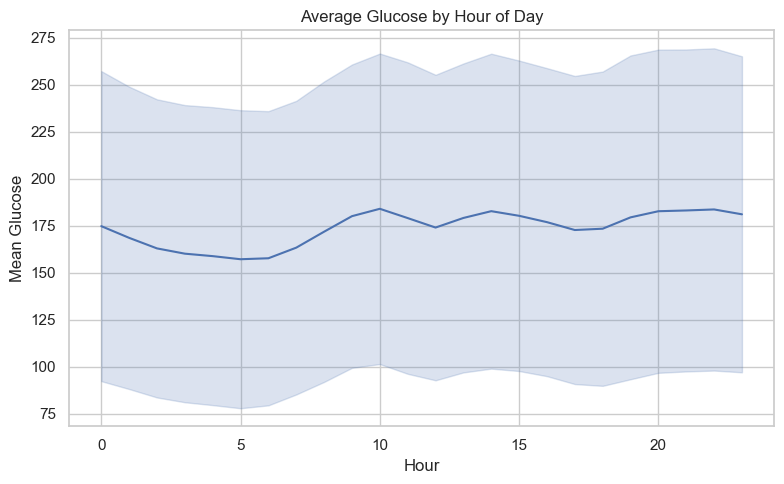

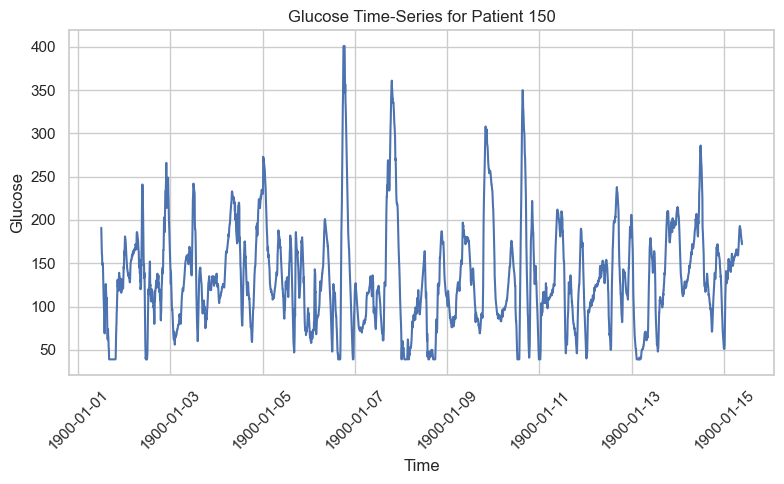

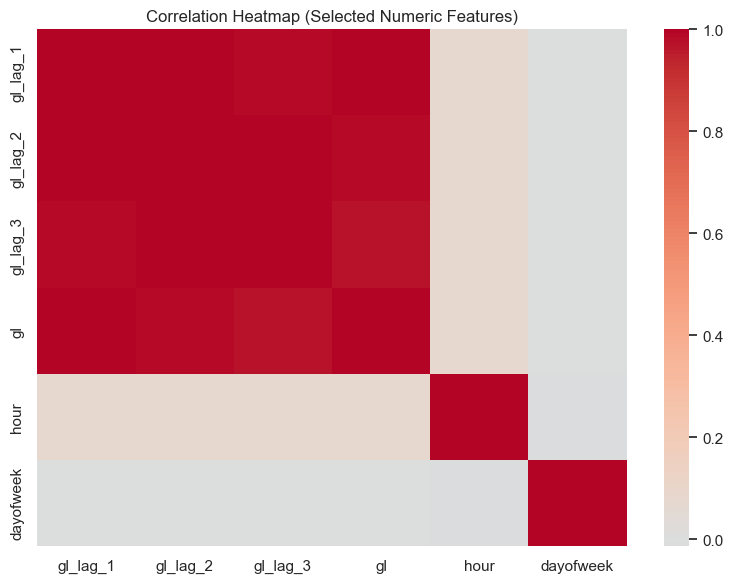

In [ ]:
# ============================================================
# Exploratory Data Analysis (EDA)
# ============================================================

# Distribution of glucose
plt.figure()
sns.histplot(df["gl"], bins=50, kde=True)
plt.title("Distribution of Glucose (gl)")
plt.xlabel("Glucose")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Time-of-day pattern
plt.figure()
sns.lineplot(x="hour", y="gl", data=df, ci="sd")
plt.title("Average Glucose by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Mean Glucose")
plt.tight_layout()
plt.show()

# Sample time series for a random patient
random_id = df["id"].sample(1, random_state=42).iloc[0]
patient_df = df[df["id"] == random_id].sort_values("time")

plt.figure()
plt.plot(patient_df["time"], patient_df["gl"])
plt.title(f"Glucose Time-Series for Patient {random_id}")
plt.xlabel("Time")
plt.ylabel("Glucose")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Correlation heatmap for numeric features (subset for readability)
numeric_cols_all = df_supervised.select_dtypes(include=[np.number]).columns.tolist()

# Only a subset to avoid a huge unreadable heatmap
subset_numeric = [c for c in numeric_cols_all if c.startswith("gl_lag_")] + ["gl", "hour", "dayofweek"]
corr = df_supervised[subset_numeric].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Selected Numeric Features)")
plt.tight_layout()
plt.show()


dtype: int64
unique codes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
EduLevel
9     210624
6     142912
10    102450
5      65101
7      51775
8      29373
11     29106
0       6864
3       3166
2       2554
1       2365
4       1568
Name: count, dtype: int64
Rows, cols: (647258, 48)

Sample columns: ['id', 'gl', 'time', 'Gender', 'Race', 'EduLevel', 'AnnualInc', 'MaritalStatus', 'DaysWkEx', 'DaysWkDrinkAlc', 'DaysMonBingeAlc', 'T1DDiagAge', 'NumHospDKA', 'NumSHSinceT1DDiag', 'InsDeliveryMethod', 'UnitsInsTotal', 'NumMeterCheckDay', 'Height', 'Weight', 'Hypertension', 'Hyperlipidemia', 'Hypothyroidism', 'Depression', 'Coronary_artery_disease', 'Diabetic_peripheral_neuropathy', 'Dyslipidemia', 'Chronic_kidney_disease', 'Osteoporosis', 'Proliferative_diabetic_retinopathy', 'Hypercholesterolemia']


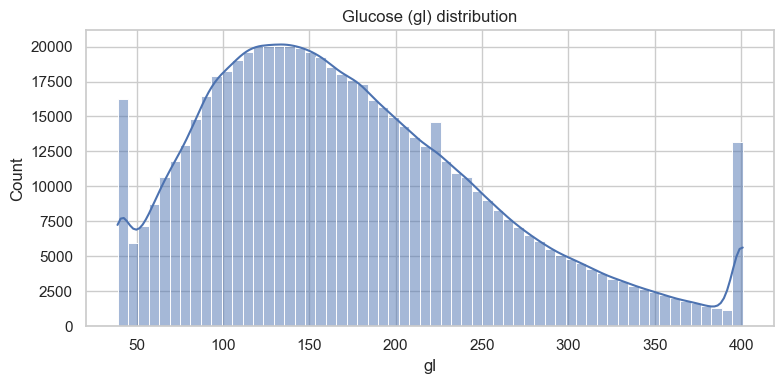

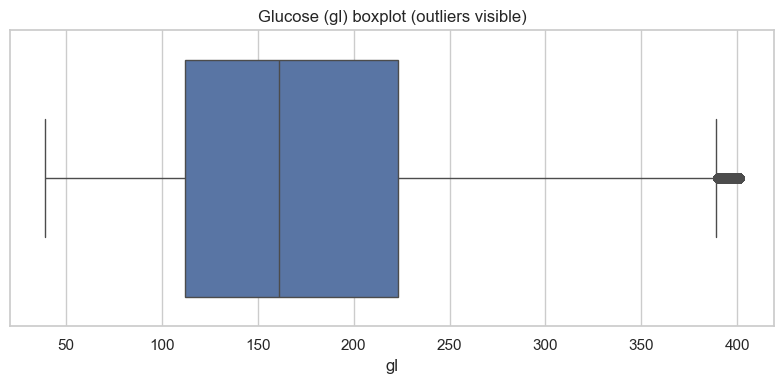

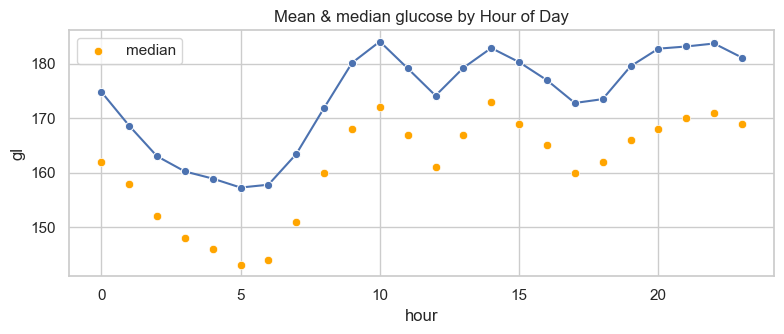

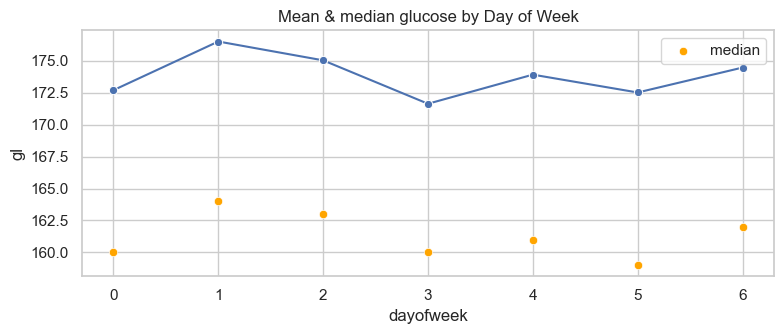

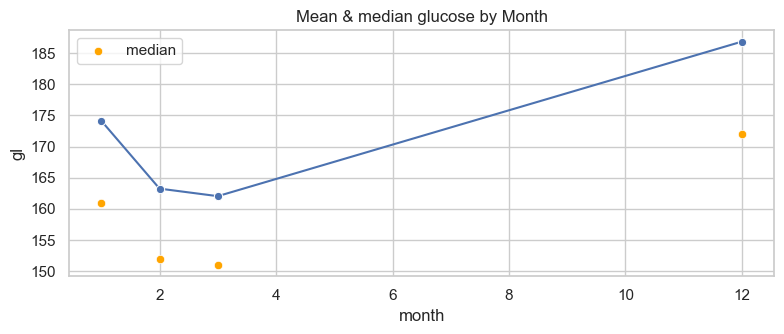

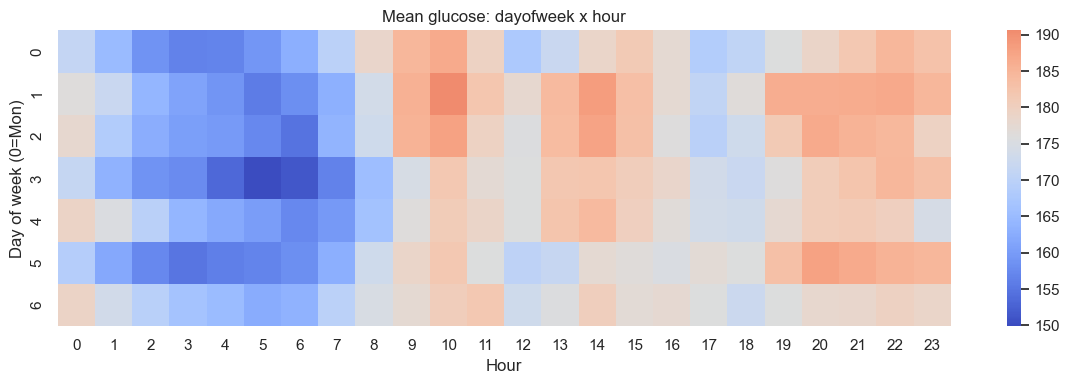

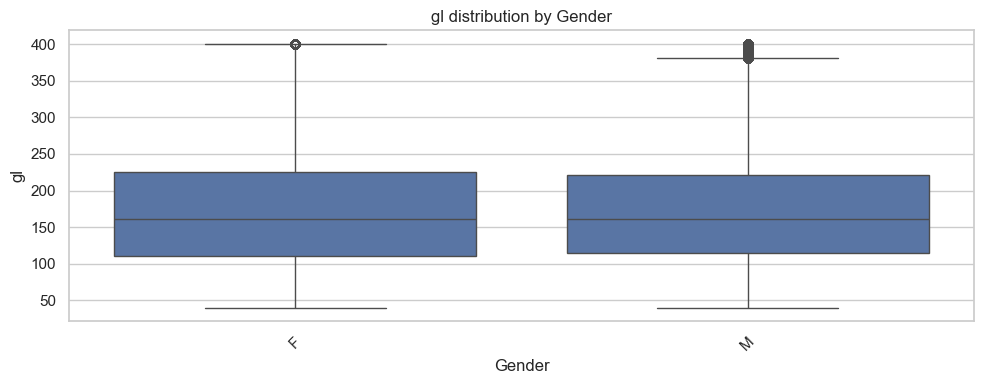

         count  median        mean
Gender                            
F       299189   161.0  174.693294
M       348069   161.0  173.161100


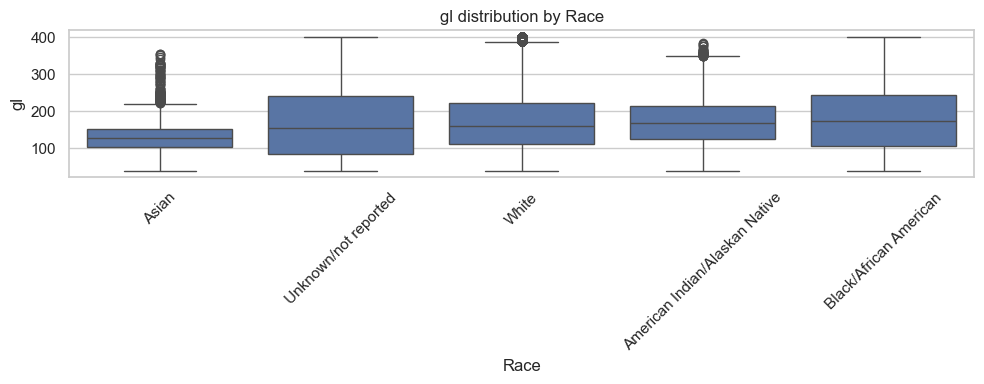

                                 count  median        mean
Race                                                      
Asian                             3720   127.0  130.225806
Unknown/not reported              1938   154.5  170.619195
White                           620676   161.0  173.877888
American Indian/Alaskan Native    2797   167.0  174.615660
Black/African American           18127   172.0  182.765543


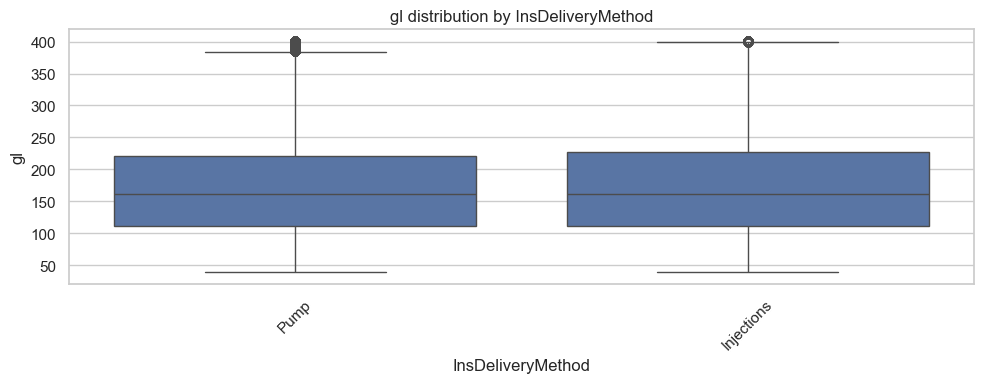

                    count  median        mean
InsDeliveryMethod                            
Pump               390592   161.0  173.056622
Injections         256666   162.0  175.106134


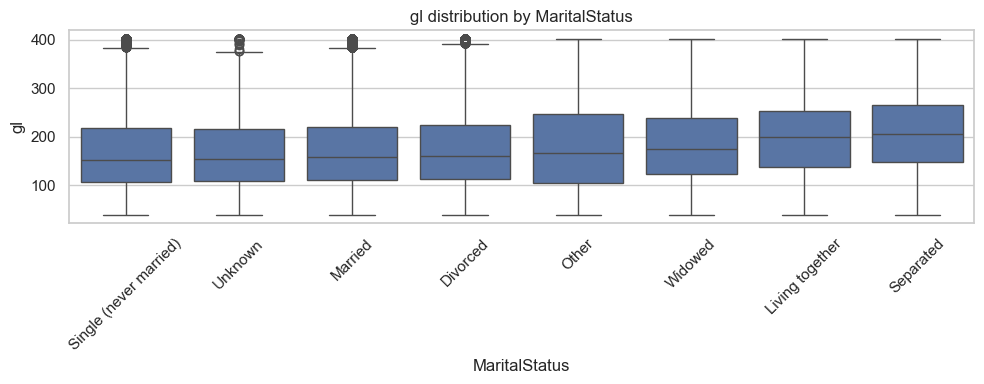

                         count  median        mean
MaritalStatus                                     
Single (never married)   35203   151.0  165.861006
Unknown                   3312   153.0  167.723430
Married                 448428   159.0  172.045171
Divorced                 93291   161.0  173.955955
Other                     6069   166.0  185.082386
Widowed                  47967   175.0  187.030083
Living together           5494   199.0  198.824718
Separated                 7494   205.0  210.667334

Top numeric correlations with gl (abs sorted):
 gl_lag_1                              0.994445
gl_lag_2                              0.985200
gl_lag_3                              0.973474
NumMeterCheckDay                     -0.107376
Diabetic_peripheral_neuropathy        0.089050
hour                                  0.075922
Erectile_dysfunction                  0.073214
Hyperlipidemia                        0.058575
Chronic_kidney_disease               -0.051132
Lisinopril        

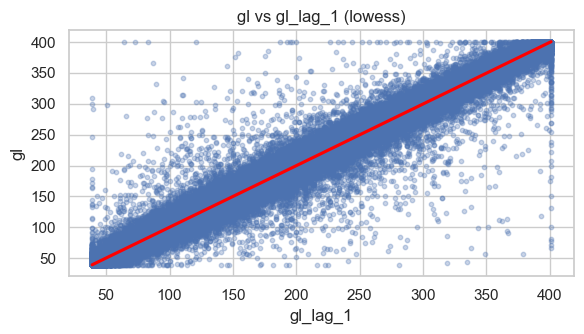

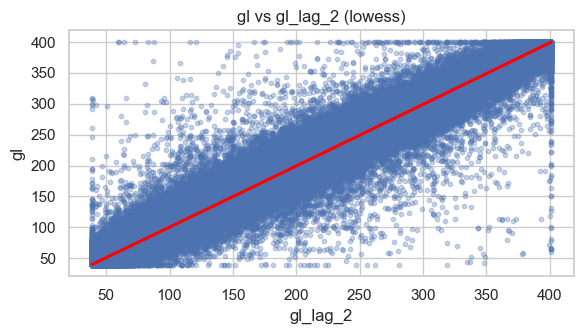

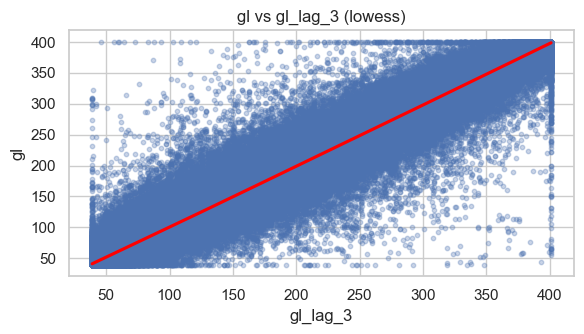

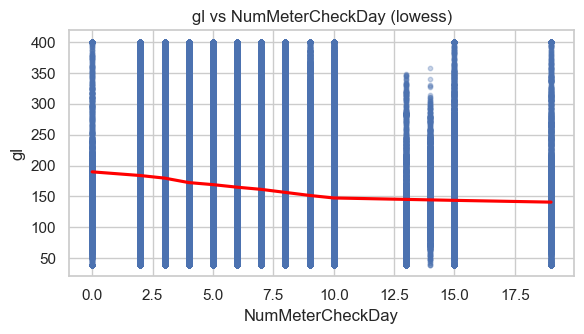

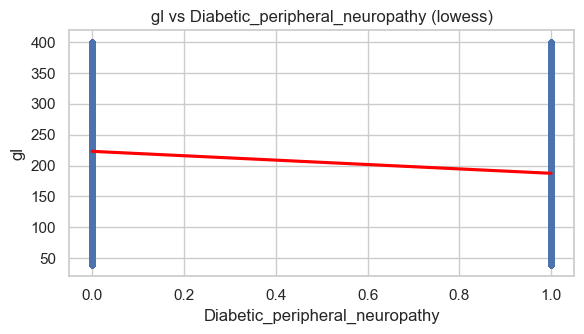

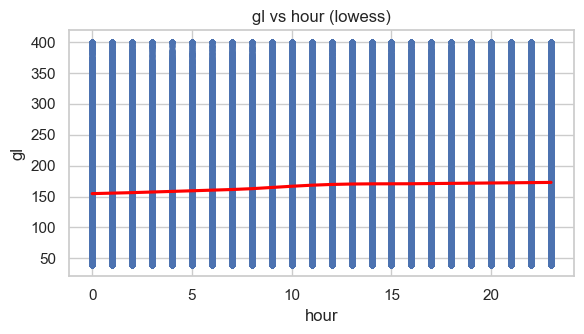

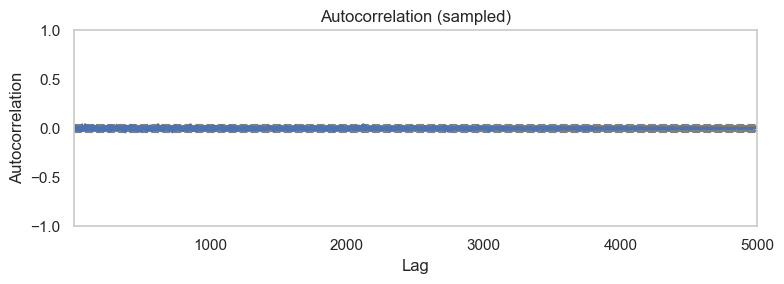

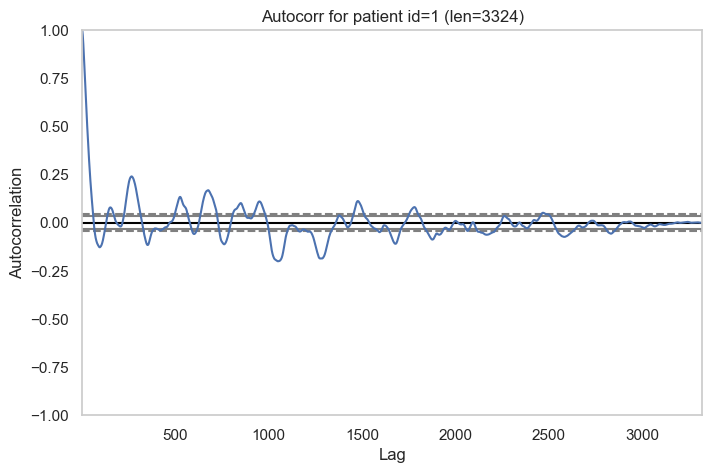

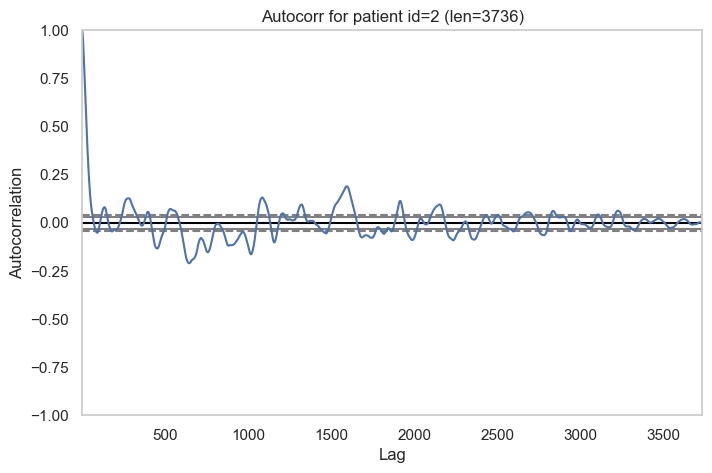

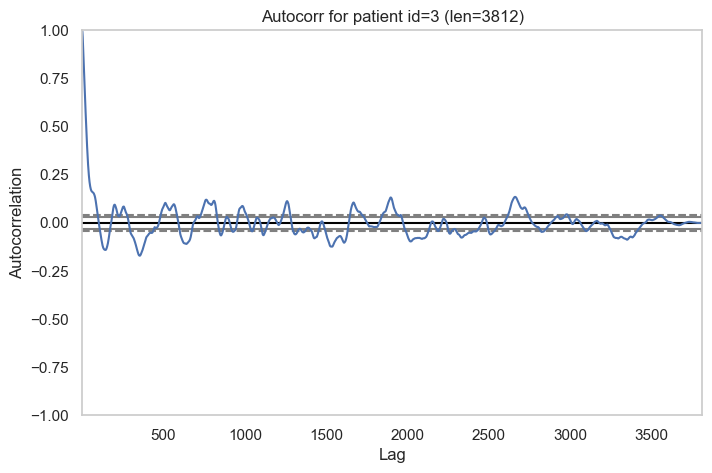


Mutual information (top features):
 gl_lag_1                2.485508
gl_lag_2                1.921481
gl_lag_3                1.598549
id                      0.151179
Weight                  0.133139
Height                  0.076090
UnitsInsTotal           0.038269
T1DDiagAge              0.034659
NumMeterCheckDay        0.013447
DaysWkDrinkAlc          0.011476
hour                    0.010505
dayofmonth              0.010484
EduLevel                0.006881
NumSHSinceT1DDiag       0.004280
Hypertension            0.004020
Race                    0.003659
AnnualInc               0.003598
MaritalStatus           0.003546
Erectile_dysfunction    0.003239
dayofweek               0.002958
dtype: float64


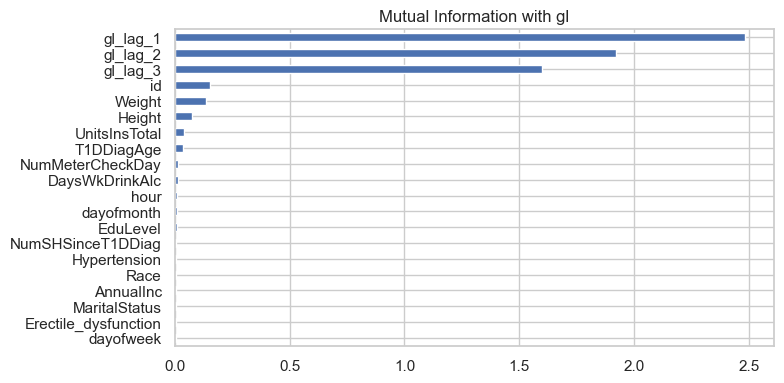


RandomForest importances (top 20):
 gl_lag_1                              0.993249
gl_lag_3                              0.001850
gl_lag_2                              0.001446
hour                                  0.000364
dayofmonth                            0.000309
id                                    0.000305
Weight                                0.000216
UnitsInsTotal                         0.000198
EduLevel                              0.000177
Height                                0.000172
Race_Unknown/not reported             0.000156
NumMeterCheckDay                      0.000148
dayofweek                             0.000145
T1DDiagAge                            0.000145
AnnualInc                             0.000089
MaritalStatus_Widowed                 0.000074
DaysWkEx                              0.000071
Proliferative_diabetic_retinopathy    0.000060
DaysWkDrinkAlc                        0.000059
NumSHSinceT1DDiag                     0.000051
dtype: float64


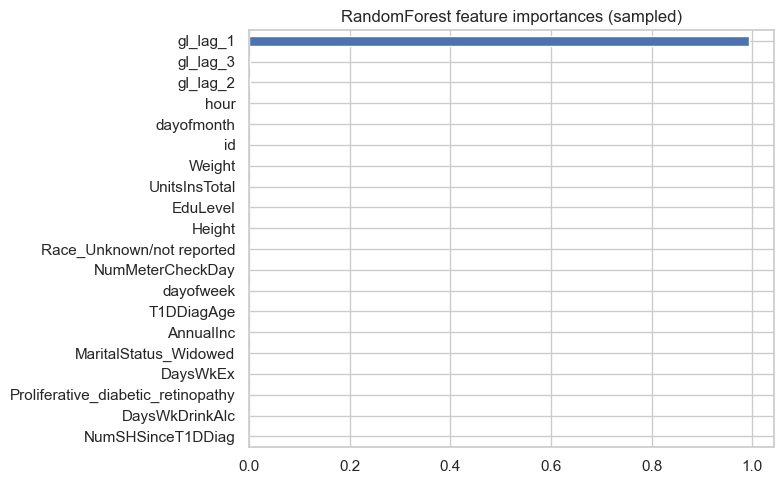


Permutation importances (top 15):
 gl_lag_1                     2.267640
gl_lag_3                     0.014780
gl_lag_2                     0.008396
hour                         0.000508
id                           0.000487
dayofmonth                   0.000373
EduLevel                     0.000303
UnitsInsTotal                0.000292
NumMeterCheckDay             0.000280
Race_Unknown/not reported    0.000233
Weight                       0.000220
T1DDiagAge                   0.000187
Height                       0.000154
dayofweek                    0.000136
MaritalStatus_Widowed        0.000110
dtype: float64


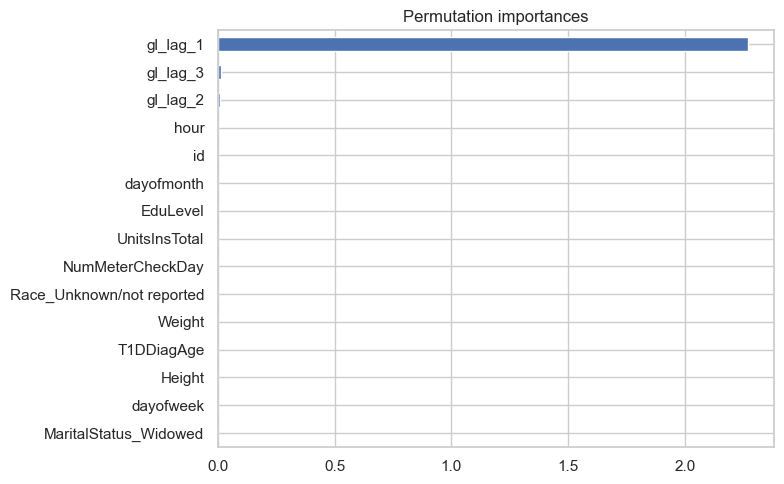


Top features to inspect: ['gl_lag_1', 'gl_lag_2', 'gl_lag_3', 'id', 'Weight', 'Height']

Feature: gl_lag_1
          count  median        mean
gl_lag_1                           
39.0      11921    39.0   39.861169
40.0        605    40.0   42.185124
41.0        698    41.0   42.540115
42.0        697    42.0   43.550933
43.0        683    43.0   44.538799
...         ...     ...         ...
397.0       175   396.0  392.822857
399.0       187   398.0  395.042781
400.0       186   398.0  395.118280
398.0       241   399.0  395.000000
401.0     11971   401.0  400.039262

[363 rows x 3 columns]

Feature: gl_lag_2
          count  median        mean
gl_lag_2                           
39.0      11919    39.0   41.303465
40.0        605    41.0   44.803306
41.0        698    41.0   45.157593
42.0        697    42.0   45.885222
43.0        684    44.0   46.561404
...         ...     ...         ...
396.0       198   395.0  389.661616
399.0       187   396.0  388.962567
398.0       242   398

In [ ]:
# ===========================
# IN-DEPTH EDA
# ===========================

import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.utils import resample

# Convert to ordered categorical (optional)
order = df.groupby("EduLevel_label")["gl"].median().sort_values().index
df["EduLevel_label"] = pd.Categorical(df["EduLevel_label"], categories=order, ordered=True)

# Use supervised dataframe with lag features if available, else fallback to df
df_ed = globals().get("df_supervised", df).copy()

# Basic dataset overview
print("Rows, cols:", df_ed.shape)
print("\nSample columns:", df_ed.columns.tolist()[:30])

# Target distribution + log-transform option
plt.figure(figsize=(8, 4))
sns.histplot(df_ed["gl"].dropna(), bins=60, kde=True)
plt.title("Glucose (gl) distribution")
plt.xlabel("gl")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.boxplot(x=df_ed["gl"])
plt.title("Glucose (gl) boxplot (outliers visible)")
plt.tight_layout()
plt.show()

# Time patterns: hour / dayofweek / month trends
for col, lab in [("hour", "Hour of Day"), ("dayofweek", "Day of Week"), ("month", "Month")]:
    if col in df_ed.columns:
        agg = df_ed.groupby(col)["gl"].agg(["mean", "median", "count"]).reset_index()
        plt.figure(figsize=(8, 3.5))
        sns.lineplot(x=col, y="mean", data=agg, marker="o")
        sns.scatterplot(x=col, y="median", data=agg, color="orange", label="median")
        plt.title(f"Mean & median glucose by {lab}")
        plt.ylabel("gl")
        plt.tight_layout()
        plt.show()

# Hour x dayofweek heatmap (if columns exist)
if {"hour", "dayofweek"}.issubset(df_ed.columns):
    pivot = df_ed.pivot_table(index="dayofweek", columns="hour", values="gl", aggfunc="mean")
    plt.figure(figsize=(12, 4))
    sns.heatmap(pivot, cmap="coolwarm", center=pivot.stack().median())
    plt.title("Mean glucose: dayofweek x hour")
    plt.xlabel("Hour")
    plt.ylabel("Day of week (0=Mon)")
    plt.tight_layout()
    plt.show()

# Categorical variables: count + distribution of gl by category (box/violin)
cat_candidates = [c for c in ["Gender", "Race", "InsDeliveryMethod", "MaritalStatus", "EduLevel_label"] if c in df_ed.columns]
for c in cat_candidates:
    plt.figure(figsize=(10, 4))
    order = df_ed.groupby(c)["gl"].median().sort_values().index
    sns.boxplot(x=c, y="gl", data=df_ed, order=order)
    plt.title(f"gl distribution by {c}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # summary table
    print(df_ed.groupby(c)["gl"].agg(["count", "median", "mean"]).sort_values("median"))

# Numeric feature -> gl correlations (Pearson) and scatter + lowess
num_cols = df_ed.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c not in ("gl", "time")]  # exclude target/time
corrs = df_ed[num_cols + ["gl"]].corr()["gl"].drop("gl").sort_values(key=lambda x: x.abs(), ascending=False)
print("\nTop numeric correlations with gl (abs sorted):\n", corrs.head(15))

top_num = corrs.head(6).index.tolist()
for c in top_num:
    plt.figure(figsize=(6, 3.5))
    sns.regplot(x=c, y="gl", data=df_ed, lowess=True, scatter_kws={"s":10, "alpha":0.3}, line_kws={"color":"red"})
    plt.title(f"gl vs {c} (lowess)")
    plt.tight_layout()
    plt.show()

# Pairplot for a small subset (lags + top numeric)
pair_vars = [c for c in ([f"gl_lag_{i}" for i in range(1,4)] + top_num) if c in df_ed.columns]
if len(pair_vars) <= 8 and len(pair_vars) >= 2:
    sns.pairplot(df_ed[pair_vars].sample(n=min(2000, len(df_ed))), diag_kind="kde", plot_kws={"s":10, "alpha":0.3})
    plt.suptitle("Pairplot (sampled)", y=1.02)
    plt.show()

# Autocorrelation / lag analysis for the target
if "gl" in df_ed.columns:
    plt.figure(figsize=(8,3))
    pd.plotting.autocorrelation_plot(df_ed["gl"].dropna().sample(n=min(5000, len(df_ed)), random_state=42))
    plt.title("Autocorrelation (sampled)")
    plt.tight_layout()
    plt.show()

    # per-patient autocorrelation example (for small number of patients)
    sample_ids = df_ed["id"].dropna().unique()[:3]
    for pid in sample_ids:
        s = df_ed.loc[df_ed["id"]==pid, "gl"].dropna()
        if len(s) > 5:
            plt.figure()
            pd.plotting.autocorrelation_plot(s)
            plt.title(f"Autocorr for patient id={pid} (len={len(s)})")
            plt.show()

# Quick feature-impact ranking: mutual information + small RF importances (sample if large)
# Prepare X,y using previously defined feature_cols if available, else auto-select
use_X = None
if "feature_cols" in globals():
    use_cols = [c for c in feature_cols if c in df_ed.columns]
    use_X = df_ed[use_cols].copy()
else:
    # pick numeric + top categoricals
    use_cols = num_cols + cat_candidates
    use_X = df_ed[use_cols].copy()

use_y = df_ed["gl"].loc[use_X.index].copy()

# Simple preprocessing for MI: encode categoricals with factorize
X_mi = use_X.copy()
for c in X_mi.select_dtypes(include=["object", "category"]).columns:
    X_mi[c] = pd.factorize(X_mi[c])[0]

# drop rows with NaN in X/y for fairness
mi_df = pd.concat([X_mi, use_y], axis=1).dropna()
X_mi_clean = mi_df[X_mi.columns]
y_mi_clean = mi_df["gl"]

# mutual information
if len(X_mi_clean) > 0 and X_mi_clean.shape[1] > 0:
    mi = mutual_info_regression(X_mi_clean, y_mi_clean, random_state=42)
    mi_ser = pd.Series(mi, index=X_mi_clean.columns).sort_values(ascending=False)
    print("\nMutual information (top features):\n", mi_ser.head(20))
    plt.figure(figsize=(8,4))
    mi_ser.head(20).plot(kind="barh")
    plt.gca().invert_yaxis()
    plt.title("Mutual Information with gl")
    plt.tight_layout()
    plt.show()

# Random forest importances on a sample (faster)
sample_size = min(20000, len(use_X))
if len(use_X) > 100:
    sampled_idx = resample(use_X.index, replace=False, n_samples=sample_size, random_state=42)
else:
    sampled_idx = use_X.index

X_rf = use_X.loc[sampled_idx].copy()
y_rf = use_y.loc[sampled_idx].copy()

# Simple encoding: one-hot small categoricals, numeric kept
X_rf_enc = pd.get_dummies(X_rf, drop_first=True)
X_rf_enc = X_rf_enc.fillna(X_rf_enc.median())

if X_rf_enc.shape[1] > 0:
    rf = RandomForestRegressor(n_estimators=200, max_depth=10, n_jobs=-1, random_state=42)
    rf.fit(X_rf_enc, y_rf)
    imp = pd.Series(rf.feature_importances_, index=X_rf_enc.columns).sort_values(ascending=False)
    print("\nRandomForest importances (top 20):\n", imp.head(20))
    plt.figure(figsize=(8,5))
    imp.head(20).plot(kind="barh")
    plt.gca().invert_yaxis()
    plt.title("RandomForest feature importances (sampled)")
    plt.tight_layout()
    plt.show()

    # permutation importance (slower; small sample)
    p = permutation_importance(rf, X_rf_enc, y_rf, n_repeats=10, random_state=42, n_jobs=2)
    pser = pd.Series(p.importances_mean, index=X_rf_enc.columns).sort_values(ascending=False)
    print("\nPermutation importances (top 15):\n", pser.head(15))
    plt.figure(figsize=(8,5))
    pser.head(15).plot(kind="barh")
    plt.gca().invert_yaxis()
    plt.title("Permutation importances")
    plt.tight_layout()
    plt.show()

# Inspect top relationships for interpretation: show group medians and counts
top_feats = list(mi_ser.head(6).index) if 'mi_ser' in globals() else (imp.head(6).index.tolist() if 'imp' in globals() else [])
print("\nTop features to inspect:", top_feats)
for f in top_feats:
    if f in df_ed.columns:
        print("\nFeature:", f)
        print(df_ed.groupby(f)["gl"].agg(["count", "median", "mean"]).sort_values("median"))


### Define Features & Target + Train/Test Split (Time-Aware)

In [12]:
# ============================================================
# 5. DEFINE FEATURES & TARGET
# ============================================================

target_col = "gl"

# Choose some useful extra features besides lags
extra_features = [
    "hour", "dayofweek", "dayofmonth", "month",
    "Gender", "Race", "EduLevel", "AnnualInc", "MaritalStatus",
    "Age", "BMI", "T1DDuration", "InsDeliveryMethod"
]

lag_features = [f"gl_lag_{lag}" for lag in range(1, MAX_LAG + 1)]

# Keep only columns that exist in dataset and are not all NaN
extra_features = [c for c in extra_features if c in df_supervised.columns]

feature_cols = lag_features + extra_features

X = df_supervised[feature_cols].copy()
y = df_supervised[target_col].copy()

# Identify categorical vs numeric columns
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numeric_cols = [c for c in X.columns if c not in categorical_cols]

print("Feature columns:", feature_cols)
print("Categorical:", categorical_cols)
print("Numeric:", numeric_cols[:10])

# ============================================================
# 6. TIME-AWARE TRAIN / TEST SPLIT
# ============================================================

# Sort again by time to ensure temporal order before splitting
df_supervised = df_supervised.sort_values("time").reset_index(drop=True)
X = df_supervised[feature_cols]
y = df_supervised[target_col]

# Simple temporal split: first 80% time steps = train, last 20% = test
split_index = int(len(df_supervised) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Feature columns: ['gl_lag_1', 'gl_lag_2', 'gl_lag_3', 'hour', 'dayofweek', 'dayofmonth', 'month', 'Gender', 'Race', 'EduLevel', 'AnnualInc', 'MaritalStatus', 'InsDeliveryMethod']
Categorical: ['Gender', 'Race', 'MaritalStatus', 'InsDeliveryMethod']
Numeric: ['gl_lag_1', 'gl_lag_2', 'gl_lag_3', 'hour', 'dayofweek', 'dayofmonth', 'month', 'EduLevel', 'AnnualInc']
Train size: (517806, 13) Test size: (129452, 13)


In [13]:
# OPTIONAL: If training is slow in Colab, downsample training for faster experiments
# sample_size = 100000
# if len(X_train) > sample_size:
#     train_idx = np.random.RandomState(42).choice(X_train.index, size=sample_size, replace=False)
#     X_train = X_train.loc[train_idx]
#     y_train = y_train.loc[train_idx]
#     print("Downsampled train size:", X_train.shape)


### Preprocessing Pipeline (OneHot + Scaling)

In [14]:
# ============================================================
# 7. PREPROCESSING PIPELINE
# ============================================================

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", StandardScaler(), numeric_cols),
    ]
)


### Helper: TimeSeriesSplit & Evaluation Function

In [15]:
# ============================================================
# 8. TIME SERIES SPLIT & EVALUATION FUNCTION
# ============================================================

tscv = TimeSeriesSplit(n_splits=3)

def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\nModel: {name}")
    print(f"MAE:  {mae:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"R²:   {r2:.3f}")

    # Plot predicted vs actual (scatter)
    plt.figure()
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.xlabel("Actual Glucose")
    plt.ylabel("Predicted Glucose")
    plt.title(f"Predicted vs Actual - {name}")
    plt.tight_layout()
    plt.show()

    # Plot residuals
    residuals = y_test - y_pred
    plt.figure()
    sns.histplot(residuals, bins=50, kde=True)
    plt.title(f"Residual Distribution - {name}")
    plt.xlabel("Residual (Actual - Predicted)")
    plt.tight_layout()
    plt.show()


In [ ]:
from sklearn.base import clone

def fit_baseline_and_tune(name, pipeline, param_grid, X_train, y_train, X_test, y_test, cv=tscv, scoring="neg_mean_absolute_error"):
    # baseline (default hyperparams)
    base = clone(pipeline)
    print(f"\n== {name} - Baseline training ==")
    base.fit(X_train, y_train)
    print(f"{name} baseline evaluation on test:")
    evaluate_model(f"{name} (baseline)", base, X_test, y_test)
    base_mae = mean_absolute_error(y_test, base.predict(X_test))

    # grid search if grid provided
    if param_grid:
        print(f"\n== {name} - GridSearchCV ==")
        grid = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grid,
            cv=cv,
            scoring=scoring,
            n_jobs=-1,
            verbose=2
        )
        grid.fit(X_train, y_train)
        print(f"Best {name} params:", grid.best_params_)
        print(f"Best {name} CV MAE:", -grid.best_score_)

        best = grid.best_estimator_
        print(f"{name} tuned evaluation on test:")
        evaluate_model(f"{name} (tuned)", best, X_test, y_test)
        tuned_mae = mean_absolute_error(y_test, best.predict(X_test))

        # compact comparison
        print(f"\n{name} MAE comparison: baseline={base_mae:.3f}  tuned={tuned_mae:.3f}  improvement={base_mae - tuned_mae:.3f}")
        return base, grid, best
    else:
        return base, None, base

### MODEL 1 – Ridge Regression (Baseline) + Grid Search

Fitting Ridge Regression grid search...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END ...................................model__alpha=0.1; total time=   0.2s
[CV] END ...................................model__alpha=1.0; total time=   0.3s
[CV] END ...................................model__alpha=0.1; total time=   0.5s
[CV] END ...................................model__alpha=1.0; total time=   0.5s
[CV] END ...................................model__alpha=0.1; total time=   0.6s
[CV] END ..................................model__alpha=10.0; total time=   0.3s
[CV] END ..................................model__alpha=50.0; total time=   0.3s
[CV] END ...................................model__alpha=1.0; total time=   0.6s
[CV] END ..................................model__alpha=10.0; total time=   0.6s
[CV] END ..................................model__alpha=10.0; total time=   0.4s
[CV] END ..................................model__alpha=50.0; total time=   0.4s
[CV] END 

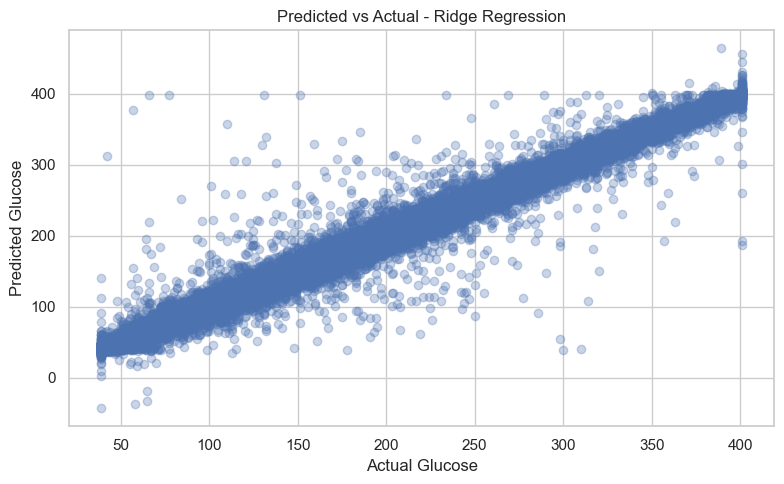

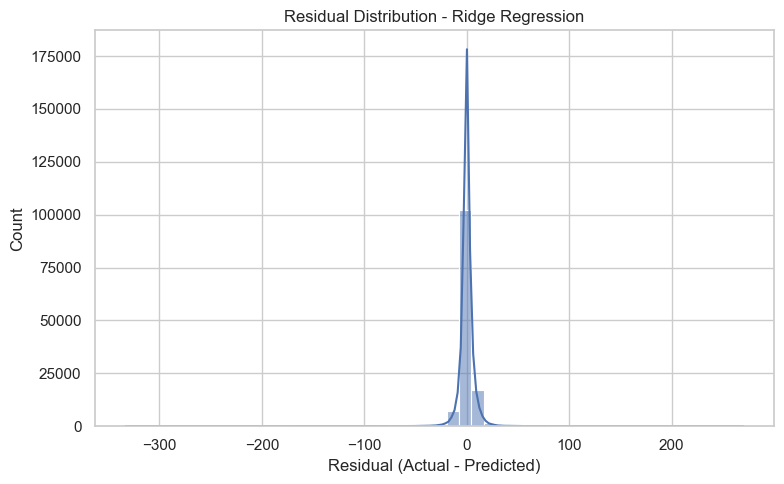

In [ ]:
# ============================================================
# 9. MODEL 1: RIDGE REGRESSION + GRIDSEARCHCV
# ============================================================

ridge_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", Ridge())
])

ridge_param_grid = {
    "model__alpha": [0.1, 1.0, 10.0, 50.0]
}

ridge_grid = GridSearchCV(
    estimator=ridge_pipeline,
    param_grid=ridge_param_grid,
    cv=tscv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=2
)
F
print("Fitting Ridge Regression grid search...")
ridge_grid.fit(X_train, y_train)

print("Best Ridge params:", ridge_grid.best_params_)
print("Best Ridge CV MAE:", -ridge_grid.best_score_)

best_ridge = ridge_grid.best_estimator_

# Evaluate on test set
evaluate_model("Ridge Regression", best_ridge, X_test, y_test)


### MODEL 2 – Random Forest Regressor + Grid Search

Fitting Random Forest grid search...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100; total time= 1.0min
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time= 1.2min
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100; total time= 2.4min
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=200; total time= 2.4min
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time= 2.6min
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=200; total time= 2.1min
[CV] END model__max_depth=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=100; tota

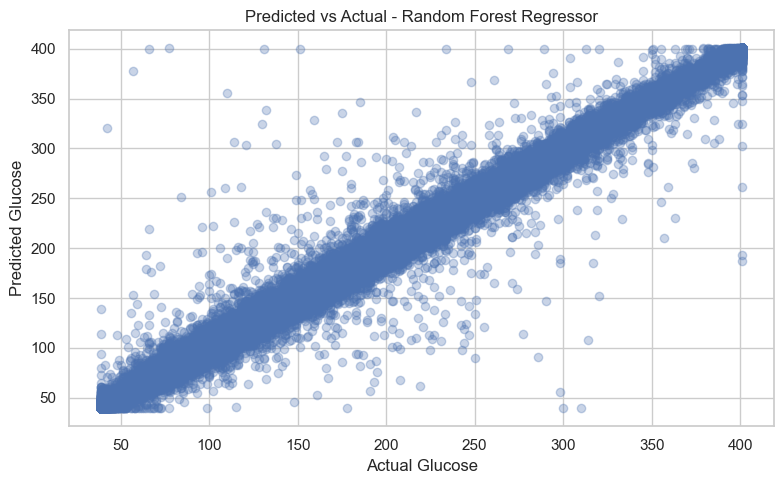

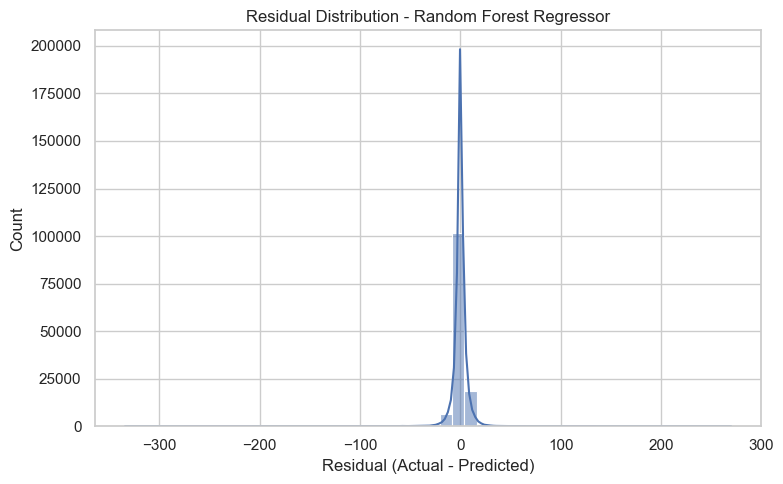

In [17]:
# ============================================================
# 10. MODEL 2: RANDOM FOREST REGRESSOR + GRIDSEARCHCV
# ============================================================

rf_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestRegressor(random_state=42))
])

rf_param_grid = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5],
    "model__min_samples_leaf": [1, 2]
}

rf_grid = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=rf_param_grid,
    cv=tscv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=2
)

print("Fitting Random Forest grid search...")
rf_grid.fit(X_train, y_train)

print("Best RF params:", rf_grid.best_params_)
print("Best RF CV MAE:", -rf_grid.best_score_)

best_rf = rf_grid.best_estimator_

# Evaluate on test set
evaluate_model("Random Forest Regressor", best_rf, X_test, y_test)


### MODEL 3 – Gradient Boosting Regressor + Grid Search

Fitting Gradient Boosting grid search...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END model__learning_rate=0.05, model__max_depth=3, model__n_estimators=100; total time=  22.2s
[CV] END model__learning_rate=0.05, model__max_depth=5, model__n_estimators=100; total time=  37.5s
[CV] END model__learning_rate=0.05, model__max_depth=3, model__n_estimators=200; total time=  47.2s
[CV] END model__learning_rate=0.05, model__max_depth=3, model__n_estimators=100; total time=  52.4s
[CV] END model__learning_rate=0.05, model__max_depth=3, model__n_estimators=100; total time= 1.4min
[CV] END model__learning_rate=0.05, model__max_depth=5, model__n_estimators=100; total time= 1.5min
[CV] END model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100; total time=  25.8s
[CV] END model__learning_rate=0.05, model__max_depth=3, model__n_estimators=200; total time= 1.8min
[CV] END model__learning_rate=0.05, model__max_depth=5, model__n_estimators=200; total time= 1.3min


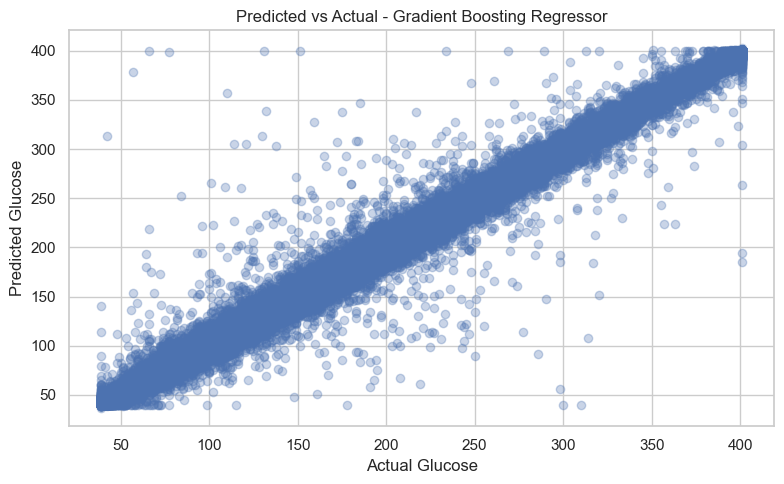

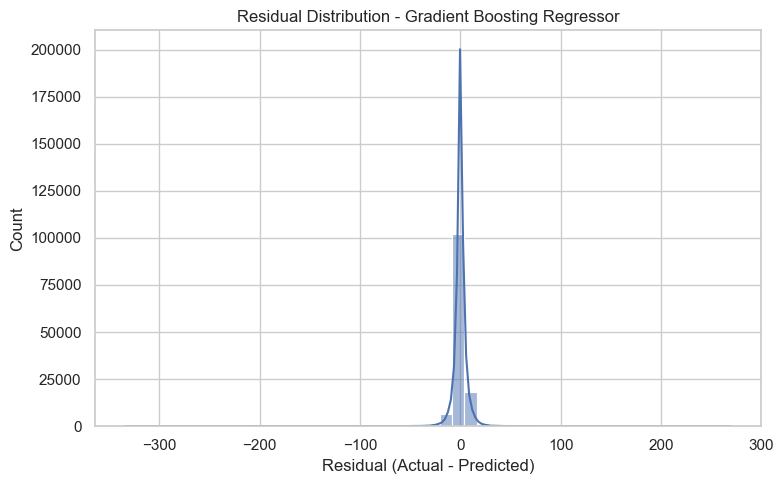

In [ ]:
# ============================================================
# 11. MODEL 3: GRADIENT BOOSTING REGRESSOR + GRIDSEARCHCV
# ============================================================

gb_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", GradientBoostingRegressor(random_state=42))
])

gb_param_grid = {
    "model__n_estimators": [100, 200],
    "model__learning_rate": [0.05, 0.1],
    "model__max_depth": [3, 5]
}

gb_grid = GridSearchCV(
    estimator=gb_pipeline,
    param_grid=gb_param_grid,
    cv=tscv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=2
)

print("Fitting Gradient Boosting grid search...")
gb_grid.fit(X_train, y_train)

print("Best GB params:", gb_grid.best_params_)
print("Best GB CV MAE:", -gb_grid.best_score_)

best_gb = gb_grid.best_estimator_

# Evaluate on test set
evaluate_model("Gradient Boosting Regressor", best_gb, X_test, y_test)
